In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_word_tr, X_char_tr, y_tr, idx_word_tr, idx_tag_tr = wc_input_converter(merged_data, train_data)
X_word_val, X_char_val, y_val, idx_word_val, idx_tag_val = wc_input_converter(merged_data, val_data)
X_word_ts, X_char_ts, y_ts, idx_word_ts, idx_tag_ts = wc_input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [7]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10
model = wc_blstm_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 100, 10, 10)  5570       ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      1344600     ['input_1[0][0]']            

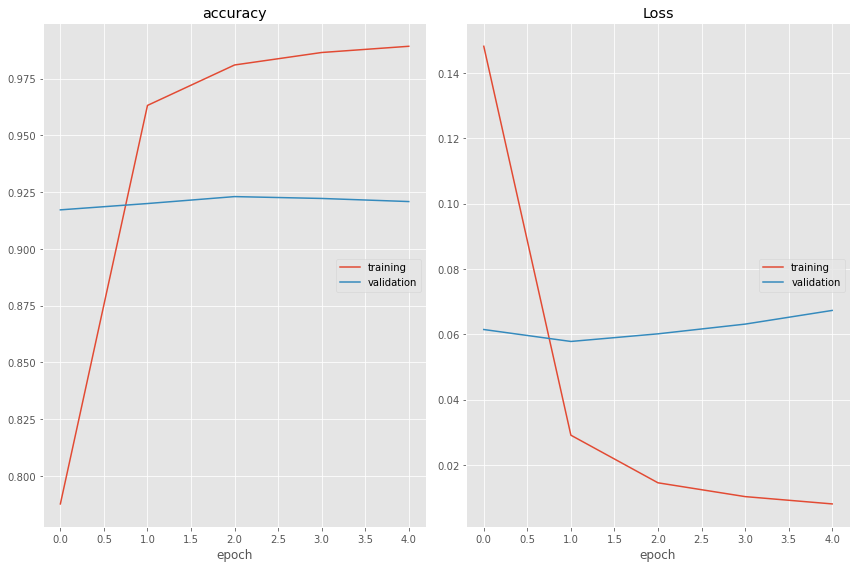

accuracy
	training         	 (min:    0.788, max:    0.989, cur:    0.989)
	validation       	 (min:    0.917, max:    0.923, cur:    0.921)
Loss
	training         	 (min:    0.008, max:    0.148, cur:    0.008)
	validation       	 (min:    0.058, max:    0.067, cur:    0.067)

Epoch 5: val_loss did not improve from 0.05779
56/56 [==============================] - 2s 43ms/step - loss: 0.0633 - accuracy: 0.9205
[0.06326234340667725, 0.9205445647239685]


In [8]:
root_path = 'model/'
model_name = 'wc_blstm_model_v2.h5'
num_epoch = 5
batch_sz = 32
callbacks = get_callbacks(root_path, model_name)

history = model.fit(x=[X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    y=np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    #validation_data=(X_word_val, y_val),
                    validation_data=(
                      [X_word_val, np.array(X_char_val).reshape((len(X_char_val),
                                                                max_len, max_len_char))],
                        np.array(y_val).reshape(len(y_val), max_len, 1)
                    ),
                    batch_size=batch_sz,
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose=1
                    )

print(model.evaluate([X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))], np.array(y_ts).reshape(len(y_ts), max_len, 1)))

In [11]:
from keras.models import load_model

mdl = load_model('model/wc_blstm_model_v2.h5')

In [12]:
predict_val = [X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))]

i = np.random.randint(0, X_word_ts.shape[0])
p = mdl.predict(predict_val)

p = np.argmax(p[i], axis=-1)
y_true = y_ts[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_ts[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))

56/56 [==============================] - 3s 38ms/step
Word                          True      	 Pred

------------------------------------------------------------
konco                         JV        	JV
dan                           ID        	ID
tonggoo                       JV        	ID
..                            O         	O
tapi                          ID        	ID
jarang                        ID        	ID
ketemu                        ID        	ID
hahahahaha                    O         	O
,                             O         	O
ga                            ID        	ID
peernah                       ID        	ID
1                             O         	O
sekola                        ID        	ID
soale                         JV        	JV
.                             O         	O
dah                           ID        	ID
jadi                          ID        	ID
abdi                          ID        	ID
negara                        ID        	ID
euy   

In [10]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_ts)):
    p = model.predict([X_word_ts,
                        np.array(X_char_ts).reshape((len(X_char_ts),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_ts[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_ts[i], y_true, p):
        if w != 0:
            # print("{:30}{:10}\t{}".format(idx_word[w], idx_tag[true], idx_tag[pred]))
            w_pair.append(idx_word_ts[w])
            true_pair.append(idx_tag_ts[true])
            pred_pair.append(idx_tag_ts[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

42/56 [=====================>........] - ETA: 0s

KeyboardInterrupt: 

In [ ]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

In [ ]:
performance_report(true_flat, pred_flat)

In [ ]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [ ]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [ ]:
true_pred_file = 'tagging_result/wc_blstm_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()